In [260]:
fn_tractor = '/global/cscratch1/sd/huikong/obiwan_Aug/repos_for_docker/obiwan_out/chunk23_test1/tractor/127/1273p255/rs2/tractor-1273p255.fits'
fn_sim = '/global/cscratch1/sd/huikong/obiwan_Aug/repos_for_docker/obiwan_out/chunk23_test1/obiwan/127/1273p255/rs2/simcat-elg-1273p255.fits'


import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt


In [261]:
tractor_dat = fits.getdata(fn_tractor)
sim_dat = fits.getdata(fn_sim)

angle = 1.5/3600

c1 = SkyCoord(ra=tractor_dat['ra']*u.degree, dec=tractor_dat['dec']*u.degree)
c2 = SkyCoord(ra=sim_dat['ra']*u.degree, dec=sim_dat['dec']*u.degree)
idx, d2d, d3d = c1.match_to_catalog_sky(c2)
w = d2d.value <= angle
idx[~w] = -1

idx1 = np.where(w)[0]
idx2 = idx[idx>-1]

print(len(tractor_dat[idx1]), len(sim_dat[idx2]))

mtc = tractor_dat[idx1]
msim = sim_dat[idx2]


sel = (mtc['flux_g']>0)&(mtc['flux_r']>0)&(mtc['flux_z']>0)&(mtc['mw_transmission_g']>0)&(mtc['mw_transmission_r']>0)&(mtc['mw_transmission_z']>0)
mtc_sel = mtc[sel]
msim_sel = msim[sel]

def select_ELG( dat , region = 'ngc'):
    """
    Given the path to a tractor catalog, it returns two sub catalogs with the eBOSS ELG selections applied (NGC and SGC).
    """
    import numpy as n
    # opens the tractor file
    # the color color selection
    g     = 22.5 - 2.5 * n.log10(dat['flux_g'] / dat['mw_transmission_g'])
    r_mag = 22.5 - 2.5 * n.log10(dat['flux_r'] / dat['mw_transmission_r'])
    z_mag = 22.5 - 2.5 * n.log10(dat['flux_z'] / dat['mw_transmission_z'])
    gr = g - r_mag
    rz = r_mag - z_mag
    color_sgc = (g>21.825)&(g<22.825)&(-0.068*rz+0.457<gr)&(gr< 0.112*rz+0.773) &(0.218*gr+0.571<rz)&(rz<-0.555*gr+1.901)
    color_ngc = (g>21.825)&(g<22.9)  &(-0.068*rz+0.457<gr)&(gr< 0.112*rz+0.773) &(0.637*gr+0.399<rz)&(rz<-0.555*gr+1.901)
    # the junk rejection criterion
    noJunk = (dat['brick_primary']) & (dat['anymask_g']==0) & (dat['anymask_r']==0) & (dat['anymask_z']==0) #& (dat['TYCHO2INBLOB']==False)
    # the low depth region rejection
    value_g=dat['psfdepth_g']
    value_r=dat['psfdepth_r']
    value_z=dat['psfdepth_z']
    gL = 62.79716079
    rL = 30.05661087
    zL_ngc = 11.0
    zL_sgc = 12.75
    depth_selection_ngc = (value_g > gL) & (value_r > rL) & (value_z > zL_ngc)
    depth_selection_sgc = (value_g > gL) & (value_r > rL) & (value_z > zL_sgc)
    # final selection boolean array :
    selection_sgc =(noJunk)&(color_sgc)&(depth_selection_sgc)
    selection_ngc =(noJunk)&(color_ngc)&(depth_selection_ngc)
    # returns the catalogs of ELGs
    if region == 'sgc':
        if len(selection_sgc.nonzero()[0])>0:
            flag = True
            return flag, dat[selection_sgc],selection_sgc
        else:
            flag = False
            return flag, dat[selection_sgc],selection_sgc
    if region == 'ngc':
            if len(selection_ngc.nonzero()[0])>0 :
                flag = True
                return flag, dat[selection_ngc],selection_ngc
            else:
                flag = False
                return flag, dat[selection_ngc],selection_ngc
            


462 462


KeyError: "Key 'mw_transmission_g' does not exist."

In [165]:
flag,elg,sel = select_ELG(mtc_sel)
elg_sim = msim_sel[sel]

In [166]:


g = 22.5 - 2.5 * np.log10(mtc_sel['flux_g'] / mtc_sel['mw_transmission_g'])
r = 22.5 - 2.5 * np.log10(mtc_sel['flux_r'] / mtc_sel['mw_transmission_r'])
z = 22.5 - 2.5 * np.log10(mtc_sel['flux_z'] / mtc_sel['mw_transmission_z'])

g_sim = 22.5 - 2.5 * np.log10(msim_sel['gflux'] / msim_sel['mw_transmission_g'])
r_sim = 22.5 - 2.5 * np.log10(msim_sel['rflux'] / msim_sel['mw_transmission_r'])
z_sim = 22.5 - 2.5 * np.log10(msim_sel['zflux'] / msim_sel['mw_transmission_z'])

(array([   1.,    0.,    1.,    0.,    0.,    5.,   13.,  148.,   15.,    2.]),
 array([-3.97167587, -3.42956352, -2.88745117, -2.34533882, -1.80322647,
        -1.26111412, -0.71900177, -0.17688942,  0.36522293,  0.90733528,
         1.44944763]),
 <a list of 10 Patch objects>)

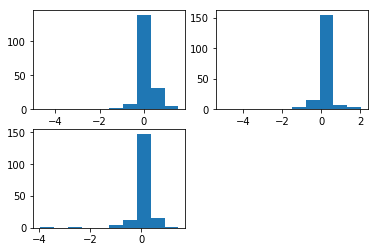

In [167]:
plt.subplot(2,2,1)
plt.hist(g-g_sim)
plt.subplot(2,2,2)
plt.hist(r-r_sim)
plt.subplot(2,2,3)
plt.hist(z-z_sim)

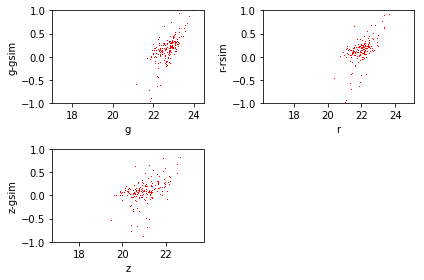

In [168]:
plt.subplot(2,2,1)
plt.plot(g,g-g_sim,'r,')
plt.xlabel('g')
plt.ylabel('g-gsim')
plt.gca().set_ylim((-1,1))
plt.subplot(2,2,2)
plt.plot(r,r-r_sim,'r,')
plt.xlabel('r')
plt.ylabel('r-rsim')
plt.gca().set_ylim((-1,1))
plt.subplot(2,2,3)
plt.plot(z,z-z_sim,'r,')
plt.xlabel('z')
plt.ylabel('z-gsim')
plt.gca().set_ylim((-1,1))
plt.tight_layout()

In [169]:
g = 22.5 - 2.5 * np.log10(elg['flux_g'] / elg['mw_transmission_g'])
r = 22.5 - 2.5 * np.log10(elg['flux_r'] / elg['mw_transmission_r'])
z = 22.5 - 2.5 * np.log10(elg['flux_z'] / elg['mw_transmission_z'])

g_sim = 22.5 - 2.5 * np.log10(elg_sim['gflux'] / elg_sim['mw_transmission_g'])
r_sim = 22.5 - 2.5 * np.log10(elg_sim['rflux'] / elg_sim['mw_transmission_r'])
z_sim = 22.5 - 2.5 * np.log10(elg_sim['zflux'] / elg_sim['mw_transmission_z'])

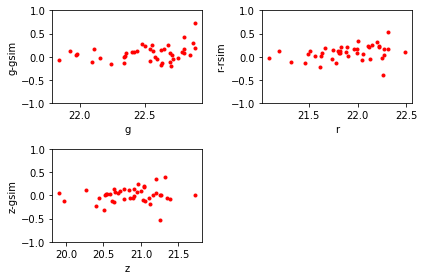

In [60]:
plt.subplot(2,2,1)
plt.plot(g,g-g_sim,'r.')
plt.xlabel('g')
plt.ylabel('g-gsim')
plt.gca().set_ylim((-1,1))
plt.subplot(2,2,2)
plt.plot(r,r-r_sim,'r.')
plt.xlabel('r')
plt.ylabel('r-rsim')
plt.gca().set_ylim((-1,1))
plt.subplot(2,2,3)
plt.plot(z,z-z_sim,'r.')
plt.xlabel('z')
plt.ylabel('z-gsim')
plt.gca().set_ylim((-1,1))
plt.tight_layout()

In [62]:
print((g-g_sim).mean())
print((r-r_sim).mean())
print((z-z_sim).mean())

0.0783443905058
0.0897248586019
0.00934192112514


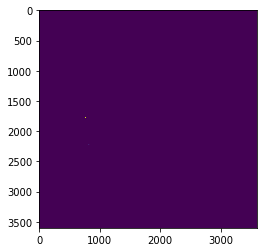

In [63]:
topdir='/global/cscratch1/sd/huikong/obiwan_Aug/repos_for_docker/obiwan_out/chunk23_test1/coadd/127/1273p255/rs2/'
fn_img = topdir+'legacysurvey-1273p255-model-g.fits.fz'
dat = fits.getdata(fn_img)
plt.imshow(dat)

Text(0.5,1,'Segmentation Image')

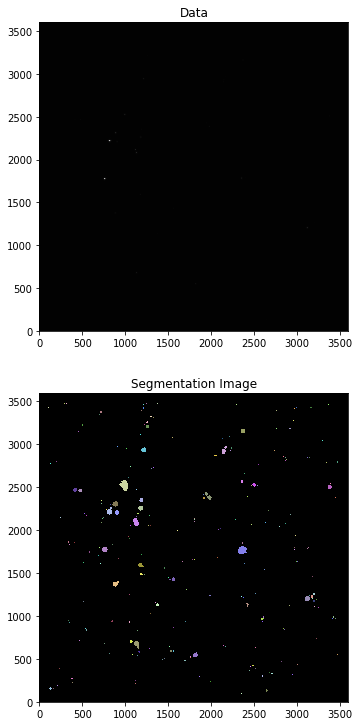

In [77]:
data=dat

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
threshold=2e-3
sigma = 3.0 * gaussian_fwhm_to_sigma    # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data, threshold, npixels=5, filter_kernel=kernel)

import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
ax2.imshow(segm, origin='lower', cmap=segm.cmap(random_state=12345))
ax2.set_title('Segmentation Image')

In [85]:
sources = np.unique(segm.data)
tot = len(sources)-1
print('found %d sources intotal' %tot)

found 336 sources intotal


source idx 6 at y,x 153.000000, 164.000000


In [121]:
def elg_filter(sources):
    lists = []
    for i in range(1,sources[-1]+1):
        y,x=np.where(segm.data==i)
        y_cen = int(y.mean())
        x_cen = int(x.mean())
        flux = data[y_cen-radius:y_cen+radius,x_cen-radius:x_cen+radius].sum()
        if flux>0.5 and flux<1.7:
            lists.append(i)
    return lists
lists = elg_filter(sources)

In [122]:
len(lists)

171

In [213]:
idx = lists[82]
y,x=np.where(segm.data==idx)
y_cen = int(y.mean())
x_cen = int(x.mean())
print('source idx %d at y,x %f, %f'%(idx,y_cen,x_cen))

source idx 160 at y,x 1706.000000, 693.000000


0.708675
3.74728


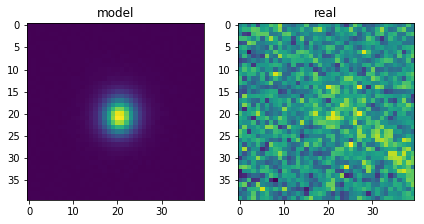

In [223]:
radius = 20
plt.subplot(1,2,1)
plt.imshow(data[y_cen-radius:y_cen+radius,x_cen-radius:x_cen+radius])
plt.title('model')
print(data[y_cen-radius:y_cen+radius,x_cen-radius:x_cen+radius].sum())
plt.subplot(1,2,2)
fn_img_real = topdir+'legacysurvey-1273p255-image-g.fits.fz'
dat_real = fits.getdata(fn_img_real)
plt.imshow(dat_real[y_cen-radius:y_cen+radius,x_cen-radius:x_cen+radius])
plt.title('real')
print(dat_real[y_cen-radius:y_cen+radius,x_cen-radius:x_cen+radius].sum())
plt.tight_layout()

In [108]:
elg['flux_g'].max(),elg['flux_g'].min()

(1.5852695, 0.591524)

In [187]:
radius=7
def elg_flux(sources):
    flux_sim = []
    flux_real = []
    for i in range(1,sources[-1]+1):
        y,x=np.where(segm.data==i)
        y_cen = int(y.mean())
        x_cen = int(x.mean())
        flux1 = data[y_cen-radius:y_cen+radius,x_cen-radius:x_cen+radius].sum()
        flux2 = dat_real[y_cen-radius:y_cen+radius,x_cen-radius:x_cen+radius].sum()
        if flux1>0.5 and flux1<1.7:
            flux_sim.append(flux1)
            flux_real.append(flux2)
    return flux_sim,flux_real

In [188]:
flux_sim,flux_real = elg_flux(sources)

In [189]:
flux_sim = np.array(flux_sim)
flux_real = np.array(flux_real)

In [190]:
(flux_sim-flux_real).mean()

-0.023866339

In [191]:
(elg['flux_g']-elg_sim['gflux']).mean()

-0.065653620146449945

Text(0.5,1,'sum over the image')

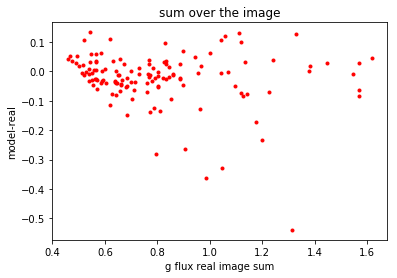

In [206]:
plt.plot(flux_real,flux_sim-flux_real,'r.')
plt.xlabel('g flux real image sum')
plt.ylabel('model-real')
plt.title('sum over the image')
#plt.gca().set_ylim((-0.4,0.25))

In [210]:
(flux_sim[(flux_sim-flux_real)>-0.2]-flux_real[(flux_sim-flux_real)>-0.2]).mean()

-0.0090571353

In [207]:
(flux_sim[(flux_sim-flux_real)>-2]-flux_real[(flux_sim-flux_real)>-2]).mean()

-0.023866339

In [212]:
sel = ((elg['flux_g']-elg_sim['gflux'])>-0.2)
(elg['flux_g'][sel]-elg_sim['gflux'][sel]).mean()

-0.026987415766191441

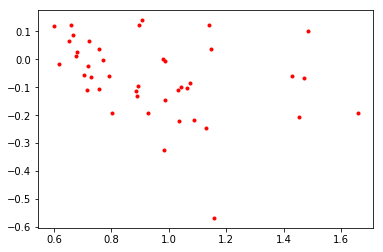

In [202]:
plt.plot(elg_sim['gflux'],elg['flux_g']-elg_sim['gflux'],'r.')

In [224]:
obiwan_w_z = fits.getdata('/global/cscratch1/sd/huikong/obiwan_Aug/repos_for_docker/obiwan_out/subset/elg_ngc_run_chunk23_really_masked.fits')

In [226]:
(obiwan_w_z['flux_g']-obiwan_w_z['gflux']).mean()

-0.075331796995230543

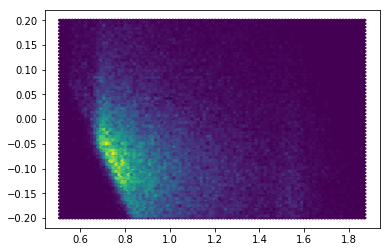

In [253]:
sel = ((obiwan_w_z['gflux']-obiwan_w_z['flux_g'])>-0.2)&((obiwan_w_z['gflux']-obiwan_w_z['flux_g'])<0.2)
plt.hexbin(obiwan_w_z['gflux'][sel],\
           obiwan_w_z['flux_g'][sel]-obiwan_w_z['gflux'][sel])
#plt.gca().set_ylim((-0.5,0.5))

In [254]:
(obiwan_w_z['flux_g'][sel]-obiwan_w_z['gflux'][sel]).mean()

-0.058454456394453624

In [229]:
elg = fits.getdata('/global/cscratch1/sd/huikong/obiwan_Aug/repos_for_docker/obiwan_out/subset/eBOSS_ELG_clustering_eboss23_v5.dat.fits')
len(elg)

52194

In [231]:
sim = fits.getdata('/global/cscratch1/sd/huikong/obiwan_Aug/repos_for_docker/obiwan_out/subset/sim_elg_ngc_run_chunk23_really_masked.fits')


(-5, 3)

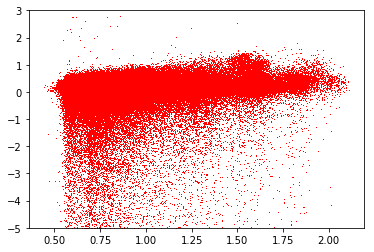

In [234]:
plt.plot(sim['gflux'],sim['gflux']-sim['flux_g'],'r,')
plt.gca().set_ylim((-5,3))

In [255]:
sel = ((sim['gflux']-sim['flux_g'])>-0.2)&((sim['gflux']-sim['flux_g'])<0.2)


In [256]:
(sim['gflux'][sel]-sim['flux_g'][sel]).mean()

0.074653833882141252

In [258]:
(sim['gflux'][sel]-sim['flux_g'][sel]).min()

-0.19999005950792437

In [259]:
topdir='/global/cscratch1/sd/huikong/obiwan_Aug/repos_for_docker/obiwan_out/subset/'
obiwan = topdir+'chunk23_test1_chunk23_really_masked.fits'
sim = topdir+'sim_chunk23_test1_chunk23_really_masked.fits'

In [274]:
obiwan_dat = fits.getdata(obiwan)
sim_dat = fits.getdata(sim)

In [277]:
sel = ((obiwan_dat['flux_g']-obiwan_dat['gflux'])>-0.2)&((obiwan_dat['flux_g']-obiwan_dat['gflux'])<0.2)
(obiwan_dat['flux_g']-obiwan_dat['gflux']).mean()

-0.030339618127996577

In [281]:
sel = ((sim_dat['gflux']-sim_dat['flux_g'])>-0.2)&((sim_dat['gflux']-sim_dat['flux_g'])<0.2)
(sim_dat['gflux'][sel]-sim_dat['flux_g'][sel]).mean()

0.058911348961708444

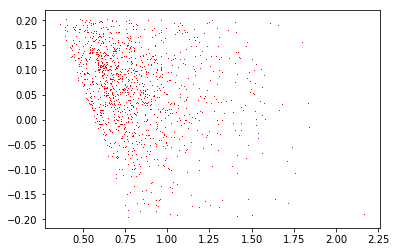

In [284]:
plt.plot(sim_dat['flux_g'][sel],sim_dat['gflux'][sel]-sim_dat['flux_g'][sel],'r,')